# Load Packages

In [105]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import time
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from tqdm import tqdm
import random
import warnings
from geopy.distance import geodesic

warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

In [194]:
random.seed(901)
np.random.seed(155)

# Get School and Coordinates

This section webscrapes the longitude and latitude coordinates for every school we are looking at (Power 5 + Big East + a few other big basketball schools) from Wikipedia. 

In [107]:
confs = ['Atlantic_Coast_Conference',
         'Big_12_Conference',
         'Big_East_Conference',
         'Big_Ten_Conference',
         'Pac-12_Conference',
         'Southeastern_Conference']

confNames = ['ACC', 'Big 12', 'Big East', 'Big Ten', 'Pac-12', 'SEC']
confDict = {}
for conf, confName in list(zip(confs, confNames)):
    confDict[conf] = confName

In [108]:
def wikiURL(conf):
    return f"https://en.wikipedia.org/wiki/{conf}"

def toSoup(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def getSchoolsTable(confSoup):
    tables = confSoup.find_all('table')
    for i in range(len(tables)):
        table = tables[i]
        headers = table.find_all('th')
        if len(headers) == 0:
            continue
        if headers[0].text == 'Institution' or 'Institution' in headers[0].text:
            return table

def teamURLs(confTable, confName):
    urlDict = {}
    teamConfDict = {}
    for row in confTable.find_all('tr')[1:]:
        if row.find('a') is None:
            continue
        collegeRef = row.find('a').get('href')
        newUrl = 'https://en.wikipedia.org' + collegeRef
        schoolName = collegeRef.replace('/wiki/', '').replace('_',' ')
        urlDict[schoolName] = newUrl
        teamConfDict[schoolName] = confName
    return urlDict, teamConfDict

def getCityCoords(sibling):
    cityRef = sibling.find('div', class_ = 'locality').find('a').get('href')
    cityURL = 'https://en.wikipedia.org' + cityRef
    citySoup = toSoup(cityURL)
    cityCoords = citySoup.find('span', class_ = 'geo-dec')
    if cityCoords is not None:
        return cityCoords.text
    return 'None'

def getSchoolCoords(urlDict):
    teamCoords = {}
    for school, teamURL in tqdm(list(urlDict.items())):
        teamSoup = toSoup(teamURL)
        for header in teamSoup.find('table', class_ = 'infobox vcard').find_all('th'):
            if header.text == 'Location':
                sibling = header.find_next_sibling()
                coord_bin = sibling.find('span', class_ = 'geo-dec')
                if coord_bin is None:
                    teamCoords[school] = getCityCoords(sibling)
                else:
                    coords = coord_bin.text
                    teamCoords[school] = coords
                time.sleep(2)
                break
    return teamCoords

def combineDicts(dictList):
    megaDict = {}
    for dct in dictList:
        for key, value in dct.items():
            megaDict[key] = value
    return megaDict

In [109]:
def campusLocations(confs):
    allDicts = []
    allConfs = []
    for conf in confs:
        url = wikiURL(conf)
        soup = toSoup(url)
        confTable = getSchoolsTable(soup)
        urlDict, teamConfDict = teamURLs(confTable, confDict[conf])
        teamCoords = getSchoolCoords(urlDict)
        allDicts.append(teamCoords)
        allConfs.append(teamConfDict)
    return combineDicts(allDicts), combineDicts(allConfs)

In [110]:
locations, teamConfs = campusLocations(confs)

100%|███████████████████████████████████████████| 14/14 [00:40<00:00,  2.90s/it]


I decided to include a few other schools, just for fun. They included some big current basketball brands in addition to SMU, only because SMU will be joining the ACC in the near future (unfortunately).  

In [111]:
otherSchools = ['Gonzaga_University', 'University_of_Memphis', 
                'Southern_Methodist_University', 'San_Diego_State_University']
otherURLDict = {}
for school in otherSchools:
    schoolName = school.replace('_', ' ')
    otherURLDict[schoolName] = 'https://en.wikipedia.org/wiki/' + school
    teamConfs[schoolName] = 'Other'
locations2 = getSchoolCoords(otherURLDict)
locations = combineDicts([locations, locations2])

100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.57s/it]


In [112]:
def toDF(locations, teamConfs):
    dataDict = {'School' : [],
                'Latitude' : [],
                'Longitude' : [],
                'Conference' : []}
    for school in locations.keys():
        dataDict['School'].append(school)
        dataDict['Conference'].append(teamConfs[school])
        loc = locations[school]
        lat, lon = loc.split(' ')
        lon = -1 * float(lon[:-2])
        lat = float(lat[:-2])
        dataDict['Latitude'].append(lat)
        dataDict['Longitude'].append(lon)
    return pd.DataFrame(dataDict)

In [113]:
school_df = toDF(locations, teamConfs)
school_df.head()

,School,Latitude,Longitude,Conference
0,Clemson University,34.67833,-82.83917,ACC
1,Duke University,35.98861,-78.90722,ACC
2,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC
3,North Carolina State University,35.78722,-78.67056,ACC
4,Wake Forest University,36.10278,-80.26083,ACC


In [114]:
def clean(fig):
    fig.update_traces(
        marker = dict(
            size = 10,
            line = dict(
                color = 'black',
                width = 1
            )
        )
    )
    
    fig.update_layout(
        height = 650,
        width = 1000,
        geo_scope = 'usa',
        paper_bgcolor = '#E4DBD7',
        margin = dict(
            l = 10,
            r = 10,
            b = 10,
            t = 60
        ),
        legend = dict(
            orientation = 'h',
            x = 0.5,
            y = 0.95,
            xanchor = 'center',
            yanchor = 'bottom',
            title = dict(
                font = dict(
                    size = 15
                )
            )
        ),
        geo = dict(
            bgcolor = "#E4DBD7",
            showland = True,
            landcolor = '#FAF9F6',
            lakecolor = 'lightblue',
            coastlinewidth = 1,
            countrycolor = 'black',
            showcountries = True,
            showsubunits = True,
            subunitcolor = 'black'
        )
    )

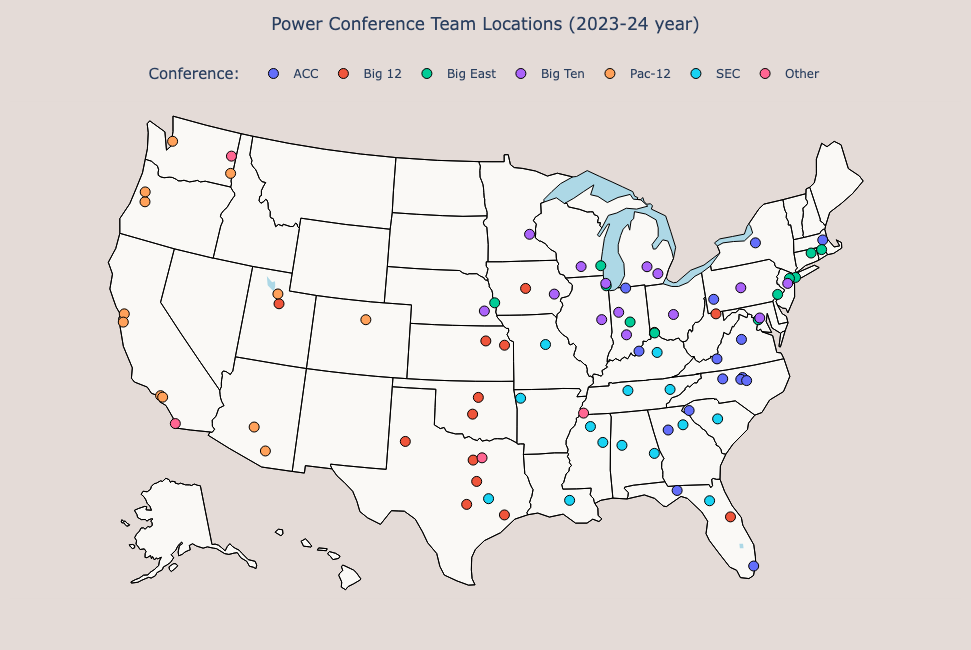

In [115]:
fig = go.Figure()
for conf in school_df['Conference'].unique():
    small_df = school_df[school_df['Conference'] == conf]
    fig.add_trace(go.Scattergeo(
        lon = small_df['Longitude'],
        lat = small_df['Latitude'],
        customdata = small_df['School'],
        mode = 'markers+text',
        hovertemplate = "School: %{customdata}<br>Conference: " + conf + "<br>Coords: (%{lat}, %{lon})",
        name = conf,
        # text = small_df['School'],
        textfont_size = 8
    ))
fig.update_layout(title = 'Power Conference Team Locations (2023-24 year)',
                  legend_title = 'Conference: ',
                  geo_scope = 'usa',
                  title_x = 0.5, title_xanchor = 'center')
clean(fig)
fig

## Clean School Names

Here, I am changing some of the names given by Wikipedia to shorter, more commonly used names (for example, we change "University of Colorado Boulder" to "Colorado"). This just makes it easier to use and look at. 

In [116]:
def cleanName(name):
    # Replace odd stuff from reading names with %'s
    replacements = {'%E2%80%93' : ' - ', '%27' : "'", '%26' : '&'}
    for key, value in replacements.items():
        name = name.replace(key, value)
    
    # Remove the prefix 'University of'
    name = name.replace('University of ', '')
    
    # Remove any words/phrases coming after 'at' or a '-'
    words = name.split(' ')
    for i in range(len(words)):
        if words[i] == 'at' or words[i] == '-':
            name = ' '.join(words[:i])
            
    # Re-split the name, remove 'University' if its the last word
    words = name.split(' ')
    if words[-1] == 'University':
        name = name.replace(' University', '')
    
    # Make special replacements
    special = {
        'North Carolina State' : 'NC State',
        'Brigham Young' : 'BYU',
        'Central Florida' : 'UCF',
        'Texas Christian' : 'TCU',
        'Connecticut' : 'UConn',
        'Providence College' : 'Providence',
        "St. John's University (New York City)" : "St. John's",
        'Indiana University Bloomington' : 'Indiana',
        'Maryland, College Park' : 'Maryland',
        'Pennsylvania State' : 'Penn State',
        'Illinois Urbana' : 'Illinois',
        'Minnesota, Twin Cities' : 'Minnesota',
        'California, Berkeley' : 'California',
        'California, Los Angeles' : 'UCLA',
        'Colorado Boulder' : 'Colorado',
        'Southern California' : 'USC',
        'Louisiana State' : 'LSU',
        'Southern Methodist' : 'SMU'
    }
    for key, value in special.items():
        if name == key:
            name = value
    return name

school_df['short_name'] = school_df['School'].apply(cleanName)

In [117]:
school_df

,School,Latitude,Longitude,Conference,short_name
0,Clemson University,34.67833,-82.83917,ACC,Clemson
1,Duke University,35.98861,-78.90722,ACC,Duke
2,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC,North Carolina
3,North Carolina State University,35.78722,-78.67056,ACC,NC State
4,Wake Forest University,36.10278,-80.26083,ACC,Wake Forest
...,...,...,...,...,...
79,Texas A%26M University,30.61028,-96.34361,SEC,Texas A&M
80,Gonzaga University,47.66750,-117.40250,Other,Gonzaga
81,University of Memphis,35.11889,-89.93722,Other,Memphis
82,Southern Methodist University,32.83855,-96.78294,Other,SMU


# Clustering

Now, to get the conferences if they were determined only by region, I used a K-means clustering algorithm. Since I did this from scratch on my own, without using any preexisting K-means packages, there are a lot of helper functions which can more or less be ignored if just looking over the code. Overall, the goal was to assign each school to the cluster center closest to them, where the centers represent the average longitude and latitude coordinates for a given cluster. In this exercise, I created the final K-means functions so you can choose two things: how many clusters (conferences) and whether each cluster / conference should have an equal (or approximately equal) number of teams. 

In [118]:
school_df

,School,Latitude,Longitude,Conference,short_name
0,Clemson University,34.67833,-82.83917,ACC,Clemson
1,Duke University,35.98861,-78.90722,ACC,Duke
2,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC,North Carolina
3,North Carolina State University,35.78722,-78.67056,ACC,NC State
4,Wake Forest University,36.10278,-80.26083,ACC,Wake Forest
...,...,...,...,...,...
79,Texas A%26M University,30.61028,-96.34361,SEC,Texas A&M
80,Gonzaga University,47.66750,-117.40250,Other,Gonzaga
81,University of Memphis,35.11889,-89.93722,Other,Memphis
82,Southern Methodist University,32.83855,-96.78294,Other,SMU


In [119]:
def getCoordDict(teams_df):
    dct = {}
    for _, row in teams_df.iterrows():
        team = row['short_name']
        dct[team] = ((row['Latitude'], row['Longitude']))
    return dct

def initialCenters(coords, num_clusters):
    options = list(coords.keys())
    teamChoices = list(np.random.choice(options, num_clusters, replace = False))
    locations = [coords[team] for team in teamChoices]
    return locations

def distance(p1, p2):
    return geodesic(p1, p2).miles

def closestCluster(coord, centers):
    minDist = 2**30 - 1
    minCenter = -1
    for i in range(len(centers)):
        if centers[i] is None:
            continue
        dist = distance(coord, centers[i])
        if dist < minDist:
            minDist = dist
            minCenter = i
    return minCenter

def clusterTeamsRaw(coords, centers, oldClusters = None):
    clusters = {}
    num_changed = 0
    for team, coord in coords.items():
        closest = closestCluster(coord, centers)
        clusters[team] = closest
        if oldClusters is not None and oldClusters[team] != closest:
            num_changed += 1
    return clusters, num_changed

def recalculateCenters(coords, clusters, num_clusters):
    clusterCoords = []
    for i in range(num_clusters):
        clusterCoords.append(([], []))
    for team, cluster in clusters.items():
        teamCoords = coords[team]
        clusterCoords[cluster][0].append(teamCoords[0])
        clusterCoords[cluster][1].append(teamCoords[1])
    for i in range(num_clusters):
        avg_x = np.mean(clusterCoords[i][0])
        avg_y = np.mean(clusterCoords[i][1])
        clusterCoords[i] = ((avg_x, avg_y))
    return clusterCoords

In [120]:
def removeFromList(teamList, removeTeam):
    newList = []
    for team, coords in teamList:
        if team != removeTeam:
            newList.append((team, coords))
    return newList

def resetClosestTeams(team, closestTeams, clusterCounts, target):
    for i in range(len(closestTeams)):
        if clusterCounts[i] == target:
            closestTeams[i] = []
        else:
            closestTeams[i] = removeFromList(closestTeams[i], team)
    return closestTeams

def makeClosestTeams(coords, centers):
    closestTeams = [[] for i in range(len(centers))]
    for team, coord in coords.items():
        for cluster, center in enumerate(centers):
            closestTeams[cluster].append((team, distance(coord, center)))
    for cluster, teamsList in enumerate(closestTeams):
        closestTeams[cluster] = sorted(teamsList, key = lambda x : x[1])
    return closestTeams

def pickTeamCluster(closestTeams):
    minDist = 2**30 - 1
    minTeam = ''
    minCluster = -1
    for i in range(len(closestTeams)):
        if len(closestTeams[i]) == 0:
            continue
        team, dist = closestTeams[i][0]
        if dist < minDist:
            minDist = dist
            minTeam = team
            minCluster = i
    return minTeam, minCluster

def checkEmpty(closestTeams):
    for i in range(len(closestTeams)):
        if len(closestTeams[i]) > 0:
            return False
    return True

def clusterTeamsEven(coords, centers, oldClusters = None):
    targetSize = math.floor(len(coords) / len(centers))
    closestTeams = makeClosestTeams(coords, centers)
    clusters = {}
    clusterCounts = [0 for i in range(len(centers))]
    for i in range(targetSize * len(centers)):
        team, cluster = pickTeamCluster(closestTeams)
        clusters[team] = cluster
        clusterCounts[cluster] += 1
        closestTeams = resetClosestTeams(team, closestTeams, clusterCounts, targetSize)

    # Assign leftover teams
    remaining = {}
    for team in coords.keys():
        if team not in set(clusters.keys()):
            remaining[team] = coords[team]
    ct2 = makeClosestTeams(remaining, centers)
    cc2 = [0 for i in range(len(centers))]
    for i in range(len(remaining)):
        team, cluster = pickTeamCluster(ct2)
        clusters[team] = cluster
        cc2[cluster] += 1
        ct2 = resetClosestTeams(team, ct2, cc2, 1)

    # Calculate number of teams that changed clusters
    if oldClusters is None:
        return clusters, 0
    num_changed = 0
    for team, cluster in clusters.items():
        if cluster != oldClusters[team]:
            num_changed += 1
    return clusters, num_changed

def clusterTeams(coords, centers, oldClusters = None, even = True):
    if even:
        return clusterTeamsEven(coords, centers, oldClusters)
    else:
        return clusterTeamsRaw(coords, centers, oldClusters)

In [121]:
def sumSquaresWithin(coords, centers, clusters, exclude = [], average = False):
    total = 0
    count = 0
    for team, cluster in clusters.items():
        if cluster in exclude:
            continue
        dist = distance(coords[team], centers[cluster])
        total += dist
        count += 1
    if average:
        return total / count
    return total

The function below represents the final clustering function. The function returns 2 elements. The first element represents the center coordinates of each cluster (in a list). The second element is a dictionary containing the teams as keys and their respective clusters as values. 

The arguments are as follows:
- `num_clusters`: The number of clusters / conferences the code should generate (I used 5 for no real reason, but it seemed to generate good results)
- `n_iter`: Number of iterations. The clustering algorithm can generate slightly different results based because it uses a little bit of randomness to initialize, so running it for more iterations increases the probability of finding the true best clusters.
- `even`: a boolean value, where True means each cluster should have an equal (or as close to equal as possible) number of teams and False means there is no restriction on how many / few teams are in each cluster 

If you have the code open in a way that you can edit it and run it, you can play around with these arguments to see the different clusters generated. 

In [181]:
# Final clustering function
def cluster(teams_df, num_clusters, n_iter = 20, even = True):
    coords = getCoordDict(teams_df)
    minSSW = 2**30-1
    minCenters = []
    minClusters = {}
    for i in tqdm(list(range(n_iter))):
        centers = initialCenters(coords, num_clusters)
        clusters, _ = clusterTeams(coords, centers, even = even)
        n_changed = -1
        num_iter = 0
        while n_changed != 0 and num_iter < 20:
            centers = recalculateCenters(coords, clusters, num_clusters)
            clusters, n_changed = clusterTeams(coords, centers, clusters, even)
            num_iter += 1
        ssw = sumSquaresWithin(coords, centers, clusters)
        if ssw < minSSW:
            minSSW = ssw
            minCenters = centers
            minClusters = clusters
    return minCenters, minClusters

In [195]:
# Create the clusters
cent, clust = cluster(school_df, num_clusters = 5, n_iter = 20, even = False)

100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.46it/s]


In [196]:
# Add the new clusters to the dataframe
school_df['cluster'] = school_df['short_name'].map(clust)
school_df

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
0,Clemson University,34.67833,-82.83917,ACC,Clemson,0,ACC,Southeast
1,Duke University,35.98861,-78.90722,ACC,Duke,1,ACC,West
2,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC,North Carolina,1,ACC,West
3,North Carolina State University,35.78722,-78.67056,ACC,NC State,1,ACC,West
4,Wake Forest University,36.10278,-80.26083,ACC,Wake Forest,1,ACC,West
...,...,...,...,...,...,...,...,...
79,Texas A%26M University,30.61028,-96.34361,SEC,Texas A&M,2,SEC,Great Plains
80,Gonzaga University,47.66750,-117.40250,Other,Gonzaga,3,Other,Midwest
81,University of Memphis,35.11889,-89.93722,Other,Memphis,0,Other,Southeast
82,Southern Methodist University,32.83855,-96.78294,Other,SMU,2,ACC,Great Plains


In [197]:
# See how many teams are in each cluster
school_df['cluster'].value_counts()

4    20
1    19
0    16
2    15
3    14
Name: cluster, dtype: int64

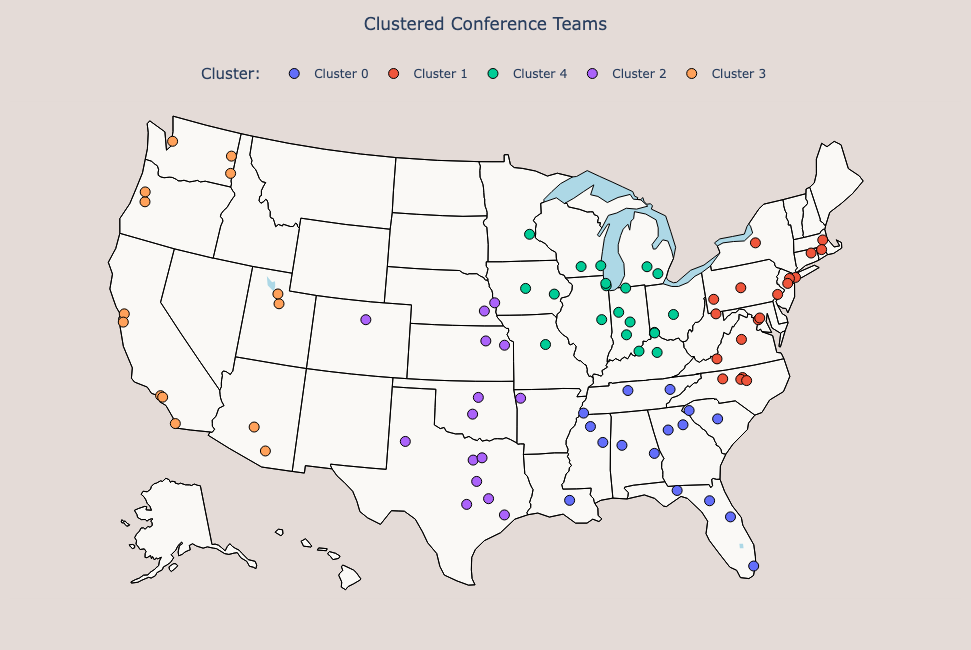

In [230]:
# Plot a map showing each team and their respective cluster
fig = go.Figure()
groupingVar = 'cluster'
for clust in school_df[groupingVar].unique():
    cname = 'Cluster ' + str(clust) if groupingVar == 'cluster' else clust
    small_df = school_df[school_df[groupingVar] == clust]
    fig.add_trace(go.Scattergeo(
        lon = small_df['Longitude'],
        lat = small_df['Latitude'],
        text = small_df['short_name'],
        mode = 'markers',
        name = cname,
    ))
fig.update_layout(height = 700, width = 900,
                  legend = dict(orientation = 'h'),
                  geo_scope = 'usa',
                  title = 'Clustered Conference Teams',
                  legend_title = 'Cluster: ',
                  title_x = 0.5, title_xanchor = 'center')
clean(fig)
fig

In [199]:
conf_changes = {
    'Oklahoma' : 'SEC',
    'Texas' : 'SEC',
    'Arizona' : 'Big 12',
    'Arizona State' : 'Big 12',
    'California' : 'ACC',
    'Colorado' : 'Big 12',
    'Oregon' : 'Big Ten',
    'Oregon State' : 'Other',
    'Stanford' : 'ACC',
    'UCLA' : 'Big Ten',
    'USC' : 'Big Ten',
    'Utah' : 'Big 12',
    'Washington' : 'Big Ten',
    'Washington State' : 'Other',
    'SMU' : 'ACC'
}

for index, row in school_df.iterrows():
    if row['short_name'] in conf_changes.keys():
        school_df.loc[index, 'new_conf'] = conf_changes[row['short_name']]
    else:
        school_df.loc[index, 'new_conf'] = row['Conference']

In [211]:
def getDist(df, conf_var, exclude = [], average = False):
    centers = {}
    confs = df[conf_var].unique()
    for c in confs:
        conf_df = df[df[conf_var] == c]
        centers[c] = (conf_df['Latitude'].mean(), conf_df['Longitude'].mean())
    
    total = 0
    count = 0
    for _, row in df.iterrows():
        if row[conf_var] in exclude:
            continue
        school_coord = (row['Latitude'], row['Longitude'])
        center_coord = centers[row[conf_var]]
        dist = distance(school_coord, center_coord)
        total += dist
        count += 1
    if average:
        return total / count
    return total

In [212]:
getDist(school_df, 'Conference', exclude = ['Other'], average = True)

354.8366402023597

In [213]:
getDist(school_df, 'cluster', average = True)

257.37520528860705

In [214]:
getDist(school_df, 'new_conf', exclude = ['Other'], average = True)

526.3515743188186

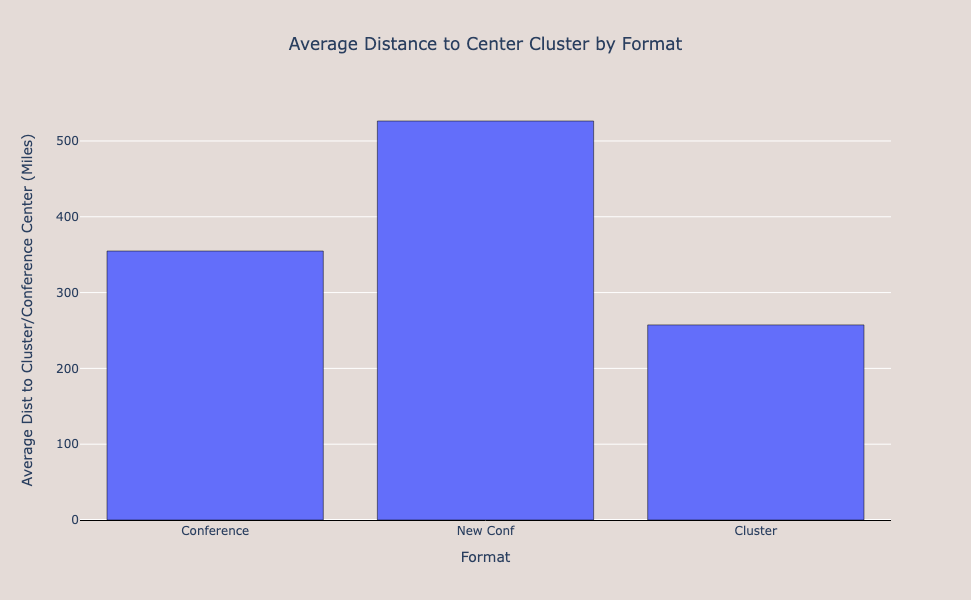

In [220]:
ssws = {'Format' : [], 'SSW' : []}
for c in ['Conference', 'new_conf', 'cluster']:
    ssws['Format'].append(c.replace('_', ' ').title())
    ssws['SSW'].append(getDist(school_df, c, exclude = ['Other'], average = True))
ssw_df = pd.DataFrame(ssws)
f = go.Figure()
f.add_trace(go.Bar(
    x = ssw_df['Format'],
    y = ssw_df['SSW'],
    marker = dict(line = dict(color = 'black'))
))
f.update_layout(width = 500, height = 600,
                paper_bgcolor = '#E4DBD7', plot_bgcolor = '#E4DBD7',
                title = "Average Distance to Center Cluster by Format",
                title_x = 0.5, title_xanchor = 'center',
                xaxis_title = 'Format',
                yaxis_title = 'Average Dist to Cluster/Conference Center (Miles)',
                xaxis_linecolor = 'black')
f

In [204]:
cluster_names = ['Southeast', 'Northeast', 'Great Plains', 'West', 'Midwest']
school_df['cluster_name'] = school_df['cluster'].apply(lambda x : cluster_names[x])
school_df

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
0,Clemson University,34.67833,-82.83917,ACC,Clemson,0,ACC,Southeast
1,Duke University,35.98861,-78.90722,ACC,Duke,1,ACC,Northeast
2,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC,North Carolina,1,ACC,Northeast
3,North Carolina State University,35.78722,-78.67056,ACC,NC State,1,ACC,Northeast
4,Wake Forest University,36.10278,-80.26083,ACC,Wake Forest,1,ACC,Northeast
...,...,...,...,...,...,...,...,...
79,Texas A%26M University,30.61028,-96.34361,SEC,Texas A&M,2,SEC,Great Plains
80,Gonzaga University,47.66750,-117.40250,Other,Gonzaga,3,Other,West
81,University of Memphis,35.11889,-89.93722,Other,Memphis,0,Other,Southeast
82,Southern Methodist University,32.83855,-96.78294,Other,SMU,2,ACC,Great Plains


In [138]:
school_df

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
0,Clemson University,34.67833,-82.83917,ACC,Clemson,0,ACC,Southeast
1,Duke University,35.98861,-78.90722,ACC,Duke,1,ACC,Northeast
2,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC,North Carolina,1,ACC,Northeast
3,North Carolina State University,35.78722,-78.67056,ACC,NC State,1,ACC,Northeast
4,Wake Forest University,36.10278,-80.26083,ACC,Wake Forest,1,ACC,Northeast
...,...,...,...,...,...,...,...,...
79,Texas A%26M University,30.61028,-96.34361,SEC,Texas A&M,2,SEC,Great Plains
80,Gonzaga University,47.66750,-117.40250,Other,Gonzaga,3,Other,West
81,University of Memphis,35.11889,-89.93722,Other,Memphis,0,Other,Southeast
82,Southern Methodist University,32.83855,-96.78294,Other,SMU,2,ACC,Great Plains


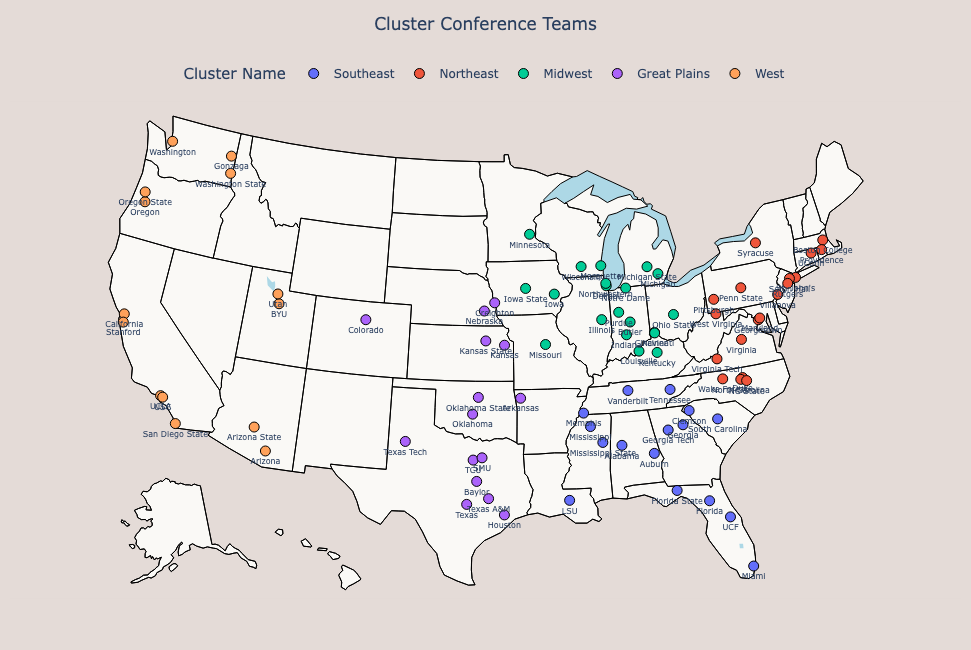

In [234]:
fig = go.Figure()
groupingVar = 'cluster_name'
for clust in school_df[groupingVar].unique():
    cname = 'Cluster ' + str(clust) if groupingVar == 'cluster' else clust
    small_df = school_df[school_df[groupingVar] == clust]
    fig.add_trace(go.Scattergeo(
        lon = small_df['Longitude'],
        lat = small_df['Latitude'],
        text = small_df['short_name'],
        textfont_size = 8,
        textposition = 'bottom center',
        mode = 'markers+text',
        name = cname
    ))
fig.update_layout(height = 700, width = 900,
                  legend = dict(orientation = 'h'),
                  geo_scope = 'usa',
                  legend_title = groupingVar.replace('_', ' ').title(),
                  title = 'Cluster Conference Teams',
                  title_x = 0.5, title_xanchor = 'center')
clean(fig)
fig

In [140]:
school_df['cluster_name'].value_counts()

Midwest         20
Northeast       19
Southeast       16
Great Plains    15
West            14
Name: cluster_name, dtype: int64

# Conference Splits (by New and Old)

## Share of Real Confs in Regional Confs

In [32]:
region_confs = school_df['cluster_name'].unique()
real_confs = school_df[school_df['new_conf'] != 'Other']['new_conf'].unique()

In [33]:
counts = school_df[['cluster_name', 'new_conf']].value_counts().reset_index().rename(columns = {0 : 'n'})
counts.head()

,cluster_name,new_conf,n
0,Northeast,Big Ten,10
1,Southeast,SEC,10
2,Great Plains,ACC,9
3,West,Big 12,8
4,Great Plains,Big East,6


In [153]:
var1 = 'new_conf'
var2 = 'cluster_name'

confTotals = []
for a in school_df[var1].unique().tolist():
    confTotals.append(len(school_df[school_df[var1] == a]))

traces = []
for b in school_df[var2].unique().tolist():
    confCounts = []
    for a in school_df[var1].unique().tolist():
        numInCluster = len(school_df[(school_df[var2] == b) & (school_df[var1] == a)])
        confCounts.append(numInCluster)
    normalized = np.array(confCounts) / np.array(confTotals)
    normalized = np.array(confCounts)
    traces.append(go.Bar(
        x = school_df[var1].unique().tolist(),
        y = normalized,
        name = b,
        marker = dict(line = dict(color = 'black'))
    ))

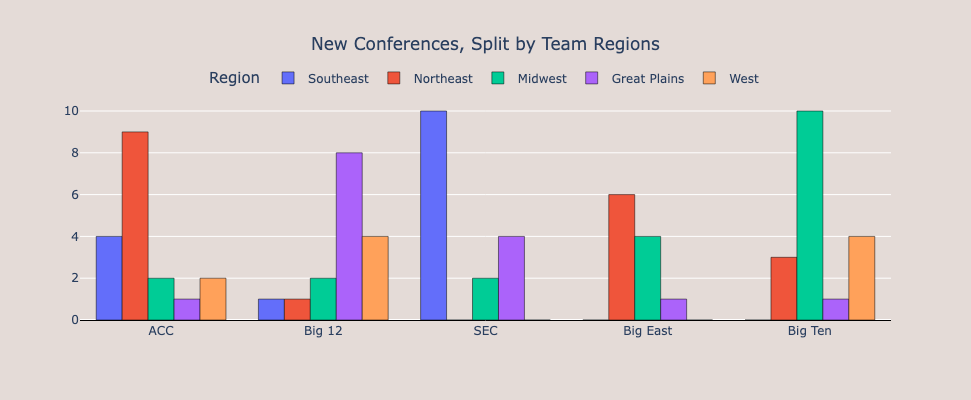

In [228]:
f = go.Figure(data = traces)
f.update_layout(xaxis_range = [-0.5,4.5],
                width = 700, height = 400,
                paper_bgcolor = '#E4DBD7', plot_bgcolor = '#E4DBD7',
                legend = dict(
                    orientation = 'h',
                    x = 0.5,
                    y = 1.03,
                    xanchor = 'center',
                    yanchor = 'bottom',
                    title = dict(
                        text = "Region",
                        font = dict(
                            size = 15
                        )
                    )
                ),
                title = "New Conferences, Split by Team Regions",
                title_x = 0.5, title_xanchor = 'center',
                xaxis_linecolor = 'black')
f

In [152]:
CONF = 'ACC'
school_df[school_df['new_conf'] == CONF][['short_name', 'new_conf', 'cluster_name']].sort_values('cluster_name')

,short_name,new_conf,cluster_name
82,SMU,ACC,Great Plains
14,Louisville,ACC,Midwest
11,Notre Dame,ACC,Midwest
1,Duke,ACC,Northeast
2,North Carolina,ACC,Northeast
3,NC State,ACC,Northeast
4,Wake Forest,ACC,Northeast
5,Virginia,ACC,Northeast
13,Syracuse,ACC,Northeast
12,Pittsburgh,ACC,Northeast


# Rankings in Each New Conference by Sport

This last part just looks at how the conferences generated using the K-means clustering (with 5 clusters and even = False) would stack up in terms of basketball and football programs. It goes by each clustered conference and ranks the teams based on their 2023 KenPom rank, their KenPom Program Rating, and their ESPN FPI rating (from the pre-season in 2023). It just gives an idea of how good each conference is. 

## Southeast

The Southeast conference wouldn't be super impressive for basketball, but it would almost undoubtedly be the best football conference ever. It includes 8 of the Top 20 ESPN FPI (Football Power Index) preseason teams, including big brands like Alabama, Clemson, LSU, Georgia, Florida State, Tennessee, and Florida. I'm sure that programs like Clemson and FSU, who put their football program first, would love this. 

In terms of basketball, this made-up conference lacks a true superpower. There are some moderately big brands like Florida and Tennessee, but the conference lacks a team with a top 10 KenPom program rating. This conference's strength is obviously football, not basketball. 

In [103]:
school_df[school_df['cluster_name'] == 'Southeast']

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
1,Clemson University,34.678330,-82.839170,ACC,Clemson,0,ACC,Southeast
3,Florida State University,30.442000,-84.298000,ACC,Florida State,0,ACC,Southeast
4,Georgia Tech,33.776000,-84.396000,ACC,Georgia Tech,0,ACC,Southeast
6,University of Miami,25.721600,-80.279300,ACC,Miami,0,ACC,Southeast
17,University of Central Florida,28.540000,-81.380000,Big 12,UCF,0,Big 12,Southeast
66,University of Florida,29.647500,-82.345000,SEC,Florida,0,SEC,Southeast
67,University of Georgia,33.955800,-83.374500,SEC,Georgia,0,SEC,Southeast
70,University of South Carolina,34.000560,-81.034720,SEC,South Carolina,0,SEC,Southeast
71,University of Tennessee,35.951670,-83.930000,SEC,Tennessee,0,SEC,Southeast
72,Vanderbilt University,36.148649,-86.804972,SEC,Vanderbilt,0,SEC,Southeast


**Southeast Basketball Rankings (using 2023 KenPom Rankings)**
- 1 Alabama (4)
- 2 Tennessee (6)
- 3 Memphis (20)
- 4 Miami (24)
- 5 Auburn (32)
- 6 Mississippi State (53)
- 7 UCF (56)
- 8 Clemson (68)
- 9 Florida (74)
- 10 Vanderbilt (81)
- 11 Mississippi (122)
- 12 LSU (151)
- 13 Georgia (154)
- 14 Georgia Tech (161)
- 15 Florida State (205)
- 16 South Carolina (221)

**Southeast Basketball Program Rankings (using KenPom Program Rankings)**
- 1 Florida (14)
- 2 Tennessee (15)
- 3 Alabama (26)
- 4 Memphis (29)
- 5 Florida State (34)
- 6 LSU (43)
- 7 Miami (44)
- 8 Auburn (45)
- 9 Clemson (49)
- 10 Mississippi State (56)
- 11 Vanderbilt (59)
- 12 Mississippi (64)
- 13 Georgia (70)
- 14 Georgia Tech (73)
- 15 South Carolina (74)
- 16 UCF (102)

**Southeast Football Rankings (using ESPN FPI as of 9/1/23)**
- 1 Alabama (2)
- 2 Georgia (3)
- 3 LSU (4)
- 4 Clemson (8)
- 5 Florida State (14)
- 6 Tennessee (15)
- 7 Ole Miss (16)
- 8 UCF (17)
- 9 Miami (22)
- 10 Florida (31)
- 11 Mississippi State (32)
- 12 Auburn (33)
- 13 South Carolina (34)
- 14 Memphis (61)
- 15 Georgia Tech (66)
- 16 Vanderbilt (82)

## Great Plains

The Great Plains conference consists of many teams from Texas, Oklahoma, and the states around them. It comprises of mostly Big 12 teams, but adds some others like Creighton, Nebraska, Colorado, and Arkansas. 

In 2023, this would have been a crazy basketball conference. Kansas, Houston, and Texas lead a group that would have had 8 top 30 KenPom teams. Of course, with the additions, the bottom of the conference is worse than what the Big 12 actually was in 2023, but its still very impressive. In terms of program ratings, the conference is weaker as only Kansas, Texas, and Baylor stand in the Top 20. For football, the conference is basically the same strength as the current Big 12, but with Texas A&M added. 

In [104]:
school_df[school_df['cluster_name'] == 'Great Plains']

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
15,Baylor University,31.548610,-97.116670,Big 12,Baylor,1,Big 12,Great Plains
19,University of Houston,29.762780,-95.383060,Big 12,Houston,1,Big 12,Great Plains
21,University of Kansas,38.958060,-95.247780,Big 12,Kansas,1,Big 12,Great Plains
22,Kansas State University,39.191670,-96.580830,Big 12,Kansas State,1,Big 12,Great Plains
23,University of Oklahoma,35.220830,-97.443610,Big 12,Oklahoma,1,SEC,Great Plains
24,Oklahoma State University%E2%80%93Stillwater,36.132220,-97.080830,Big 12,Oklahoma State,1,Big 12,Great Plains
25,University of Texas at Austin,30.285000,-97.735000,Big 12,Texas,1,SEC,Great Plains
26,Texas Christian University,32.756390,-97.332500,Big 12,TCU,1,Big 12,Great Plains
27,Texas Tech University,33.584000,-101.878000,Big 12,Texas Tech,1,Big 12,Great Plains
31,Creighton University,41.264720,-95.946110,Big East,Creighton,1,Big East,Great Plains


**Great Plains Basketball Rankings (using 2023 KenPom Rankings)**
- 1 Houston (2)
- 2 Texas (5)
- 3 Kansas (9)
- 4 Creighton (12)
- 5 Baylor (16)
- 6 Kansas State (21)
- 7 Arkansas (22)
- 8 TCU (25)
- 9 Texas A&M (33)
- 10 Oklahoma State (46)
- 11 Oklahoma (54)
- 12 Texas Tech (63)
- 13 Colorado (70)
- 14 Nebraska (94)
- 15 SMU (183)

**Great Plains Historical Basketball Rankings (using KenPom Program Ratings)**
- 1 Kansas (3)
- 2 Texas (13)
- 3 Baylor (20)
- 4 Arkansas (28)
- 5 Oklahoma (30)
- 6 Oklahoma State (32)
- 7 Creighton (40)
- 8 Texas Tech (42)
- 9 Kansas State (50)
- 10 Houston (53)
- 11 Texas A&M (61)
- 12 Colorado (65)
- 13 Nebraska (81)
- 14 TCU (82)
- 15 SMU (94)

**Great Plains Football Rankings (using ESPN FPI as of 9/1/23)**
- 1 Texas (5)
- 2 Oklahoma (11)
- 3 Texas A&M (18)
- 4 TCU (20)
- 5 Texas Tech (21)
- 6 Kansas State (26)
- 7 Baylor (27)
- 8 Arkansas (28)
- 9 Oklahoma State (41)
- 10 SMU (49)
- 11 Nebraska (51)
- 12 Houston (57)
- 13 Kansas (64)
- 14 Colorado (101)
- N/A Creighton

## West

The West conference is interesting as it consists of 11 of the 12 Pac-12 teams. The Pac-12 is going to disappear, but in these clusters the West is essentially the Pac-12 + BYU, Gonzaga, and SDSU. For basketball, we're basically looking at the best of the conference consisting of UCLA, Arizona, Gonzaga, USC, Oregon, and SDSU. The games between Gonzaga, Arizona, and UCLA (all of which are in the top 11 in KenPom program ratings) would be very fun to watch year in and year out. 

For football, the additions of Gonzaga and SDSU don't do much, but I guess BYU adds a little bit. Otherwise, its basically just the same as the current Pac-12 in terms of strength. 

In [106]:
school_df[school_df['cluster_name'] == 'West']

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
16,Brigham Young University,40.25083,-111.64917,Big 12,BYU,2,Big 12,West
54,University of Arizona,32.22167,-110.92639,Pac-12,Arizona,2,Big 12,West
55,Arizona State University,33.41278,-111.94306,Pac-12,Arizona State,2,Big 12,West
56,"University of California, Berkeley",37.87190,-122.25850,Pac-12,California,2,ACC,West
57,"University of California, Los Angeles",34.06944,-118.44528,Pac-12,UCLA,2,Big Ten,West
59,University of Oregon,44.05194,-123.08667,Pac-12,Oregon,2,Big Ten,West
60,Oregon State University,44.56390,-123.27470,Pac-12,Oregon State,2,Other,West
61,University of Southern California,34.02167,-118.28528,Pac-12,USC,2,Big Ten,West
62,Stanford University,37.42750,-122.17000,Pac-12,Stanford,2,ACC,West
63,University of Utah,40.76083,-111.89111,Pac-12,Utah,2,Big 12,West


**West Basketball Rankings (using 2023 KenPom Rankings)**
- 1 UCLA (3)
- 2 Gonzaga (8)
- 3 Arizona (11)
- 4 San Diego State (14)
- 5 Oregon (42)
- 6 USC (45)
- 7 Arizona State (55)
- 8 Washington State (67)
- 9 Utah (75)
- 10 BYU (77)
- 11 Stanford (84)
- 12 Washington (107)
- 13 Oregon State (214)
- 14 California (270)

**West Historical Basketball Rankings (using KenPom Program Ratings)**
- 1 Gonzaga (6)
- 2 Arizona (7)
- 3 UCLA (11)
- 4 Oregon (21)
- 5 USC (33)
- 6 Stanford (36)
- 7 BYU (47)
- 8 Utah (57)
- 9 Washington (58)
- 10 Arizona State (66)
- 11 San Diego State (68)
- 12 California (79)
- 13 Washington State (89)
- 14 Oregon State (104)

**West Football Rankings (using ESPN FPI as of 9/1/23)**
- 1 USC (9)
- 2 Oregon (12)
- 3 Utah (13)
- 4 Washington (24)
- 5 Oregon State (30)
- 6 UCLA (35)
- 7 California (47)
- 8 Arizona (52)
- 9 BYU (63)
- 10 Washington State (67)
- 11 Stanford (74)
- 12 San Diego State (87)
- 13 Arizona State (92)
- N/A Gonzaga

## Midwest

The Midwest cluster consists of a lot of Big Ten teams, but also with a mix of Big East teams and a few teams from the ACC, Big 12, and SEC. The cluster is by far the largest at 20 teams. This theoretical conference would be great in basketball, as it includes great Big Ten programs like Michigan State, Ohio State, Michigan, Purdue, and Indiana but also adds historical programs like Louisville, Kentucky, Xavier, and Cincinnati. Overall, the cluster includes 10 top 30 KenPom program rating teams! 

Switching to football, this conference would still be very strong as it includes Ohio State and Michigan, but also adds Notre Dame (who the Big Ten has been seeking in real life for a while). 

In [108]:
school_df[school_df['cluster_name'] == 'Midwest']

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
5,University of Louisville,38.215000,-85.760280,ACC,Louisville,3,ACC,Midwest
9,University of Notre Dame,41.700000,-86.238890,ACC,Notre Dame,3,ACC,Midwest
18,University of Cincinnati,39.131000,-84.516000,Big 12,Cincinnati,3,Big 12,Midwest
20,Iowa State University,42.026110,-93.648330,Big 12,Iowa State,3,Big 12,Midwest
29,Butler University,39.839440,-86.171390,Big East,Butler,3,Big East,Midwest
32,DePaul University,41.924000,-87.656000,Big East,DePaul,3,Big East,Midwest
34,Marquette University,43.039170,-87.932500,Big East,Marquette,3,Big East,Midwest
39,Xavier University,39.100000,-84.512500,Big East,Xavier,3,Big East,Midwest
40,Indiana University Bloomington,39.167222,-86.521389,Big Ten,Indiana,3,Big Ten,Midwest
42,University of Michigan,42.276940,-83.738060,Big Ten,Michigan,3,Big Ten,Midwest


**Midwest Basketball Rankings (using 2023 KenPom Rankings)**
- 1 Purdue (7)
- 2 Marquette (10)
- 3 Xavier (15)
- 4 Michigan State (26)
- 5 Kentucky (27)
- 6 Iowa State (29)
- 7 Indiana (30)
- 8 Illinois (35)
- 9 Northwestern (38)
- 10 Iowa (41)
- 11 Michigan (44)
- 12 Ohio State (49)
- 13 Cincinnati (50)
- 14 Missouri (57)
- 15 Wisconsin (61)
- 16 Butler (119)
- 17 DePaul (135)
- 18 Notre Dame (166)
- 19 Minnesota (216)
- 20 Louisville (290)

**Midwest Historical Basketball Rankings (using KenPom Program Ratings)**
- 1 Kentucky (2)
- 2 Michigan State (5)
- 3 Ohio State (9)
- 4 Louisville (12)
- 5 Michigan (16)
- 6 Illinois (18)
- 7 Wisconsin (19)
- 8 Purdue (22)
- 9 Indiana (24)
- 10 Xavier (27)
- 11 Cincinnati (31)
- 12 Notre Dame (37)
- 13 Iowa State (38)
- 14 Marquette (39)
- 15 Iowa (41)
- 16 Butler (52)
- 17 Missouri (54)
- 18 Minnesota (62)
- 19 Northwestern (85)
- 20 DePaul (99)

**Midwest Football Rankings (using ESPN FPI as of 9/1/23)**
- 1 Ohio State (1)
- 2 Michigan (6)
- 3 Notre Dame (7)
- 4 Wisconsin (19)
- 5 Kentucky (25)
- 6 Michigan State (36)
- 7 Iowa (37)
- 8 Iowa State (39)
- 9 Missouri (40)
- 10 Louisville (42)
- 11 Illionis (44)
- 12 Minnesota (45)
- 13 Cincinnati (48)
- 14 Purdue (50)
- 15 Northwestern (65)
- 16 Indiana (68)

## Northeast

Lastly, we have the Northeast cluster. This cluster is a mix of mostly ACC teams and Big East teams, but also includes some of the Big Ten teams on the East Coast. Looking at this conference, we see a ton of good academic schools (like Duke, UNC, Villanova, Virginia, Georgetown) and some interesting traits in terms of basketball and football programs. 

First, there are a lot of historically good basketball programs in this cluster. It includes Duke, North Carolina, Villanova, UConn (defending Champs), Virginia, Syracuse, and Maryland, all of whom have a top 25 KenPom program rating. That is a group which pretty much includes the historically good ACC teams + UConn and Maryland. We would get some great matchups, like the Duke vs Maryland rivalry. In addition, we would expect to see a few realistic title contenders from this cluster year in and year out.

In football, however, this cluster is not very good. Its best program is Penn State (which feels kind of weird to be in this kind of basketball centric cluster, but the K-means clustering didn't care about that, it only cared about distance), and it only has 3 teams ranked in the top 30 of ESPN's preseason FPI rankings. Basically, its a really weak football conference. 

In [109]:
school_df[school_df['cluster_name'] == 'Northeast']

,School,Latitude,Longitude,Conference,short_name,cluster,new_conf,cluster_name
0,Boston College,42.33500,-71.17028,ACC,Boston College,4,ACC,Northeast
2,Duke University,35.98861,-78.90722,ACC,Duke,4,ACC,Northeast
7,University of North Carolina at Chapel Hill,35.90861,-79.04917,ACC,North Carolina,4,ACC,Northeast
8,North Carolina State University,35.78722,-78.67056,ACC,NC State,4,ACC,Northeast
10,University of Pittsburgh,40.44460,-79.95330,ACC,Pittsburgh,4,ACC,Northeast
11,Syracuse University,43.03760,-76.13400,ACC,Syracuse,4,ACC,Northeast
12,University of Virginia,38.03556,-78.50333,ACC,Virginia,4,ACC,Northeast
13,Virginia Tech,37.22500,-80.42500,ACC,Virginia Tech,4,ACC,Northeast
14,Wake Forest University,36.10278,-80.26083,ACC,Wake Forest,4,ACC,Northeast
28,West Virginia University,39.63582,-79.95453,Big 12,West Virginia,4,Big 12,Northeast


**Northeast Basketball Rankings (using 2023 KenPom Rankings)**
- 1 UConn (1)
- 2 Duke (18)
- 3 West Virginia (19)
- 4 Maryland (23)
- 5 Virginia (34)
- 6 Penn State (36)
- 7 Rutgers (39)
- 8 Providence (40)
- 9 North Carolina (43)
- 10 Villanova (51)
- 11 NC State (52)
- 12 Seton Hall (58)
- 13 Pittsburgh (59)
- 14 Virginia Tech (80)
- 15 St John's (82)
- 16 Wake Forest (86)
- 17 Syracuse (118)
- 18 Boston College (170)
- 19 Georgetown (219)

**Midwest Historical Basketball Rankings (using KenPom Program Ratings)**
- 1 Duke (1)
- 2 North Carolina (4)
- 3 Villanova (8)
- 4 UConn (10)
- 5 Virginia (17)
- 6 Maryland (23)
- 7 Syracuse (25)
- 8 West Virginia (35)
- 9 Pittsburgh (46)
- 10 Georgetown (48)
- 11 NC State (51)
- 12 Providence (55)
- 13 Seton Hall (60)
- 14 Virginia Tech (63)
- 15 Wake Forest (69)
- 16 St John's (76)
- 17 Penn State (77)
- 18 Rutgers (83)
- 19 Boston College (86)

**Northeast Football Rankings (using ESPN FPI as of 9/1/23)**
- 1 Penn State (10)
- 2 North Carolina (23)
- 3 Pittsburgh (29)
- 4 Syracuse (38)
- 5 NC State (43)
- 6 Maryland (46)
- 7 Wake Forest (53)
- 8 West Virginia (58)
- 9 Duke (59)
- 10 Virginia Tech (62)
- 11 Rutgers (75)
- 12 Virginia (76)
- 13 Boston College (77)
- 14 UConn (113)

## Summary

**Best Basketball Conferences (Now)**
- 1 Great Plains
- 2 Midwest
- 3 Northeast
- 4 West
- 5 Southeast

**Best Basketball Conferences (Historical)**
- 1 Midwest
- 2 Northeast
- 3 Great Plains
- 4 Southeast
- 5 West

**Best Football Conferences**
- 1 Southeast
- 2 Great Plains
- 3 Midwest
- 4 West
- 5 Northeast